# Importar Librerias

In [1]:
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt
import openpyxl 
import pandas as pd
import numpy as np

# Importación de Datos

In [2]:
# Datos globales
nref  = 1          # nodo de referencia
vref  = 1.0        # tensión en la subestación (pu)
vbase = 12.66      # Tensión base (kV)
sbase = 10000       # Potencia base (kVA)
tol   = 10**-8      # Tolerancia del error permitido
vmin  = 0.93*vbase       # Tensión mínima (pu)
vmax  = 1.05*vbase       # Tensión máxima (pu)
delV=vmax-vmin

# Base de impedancia
zbase = 1000*((vbase**2)/sbase)

# Datos de ramas
#         de   para  R(ohm)  X(ohm)
ramos = [
            [1, 2, 0.0922, 0.0470],
            [2, 3, 0.4930, 0.2511],
            [3, 4, 0.3660, 0.1864],
            [4, 5, 0.3811, 0.1941],
            [5, 6, 0.8190, 0.7070],
            [6, 7, 0.1872, 0.6188],
            [7, 8, 0.7114, 0.2351],
            [8, 9, 1.0300, 0.7400],
            [9, 10, 1.0440, 0.7400],
            [10, 11, 0.1966, 0.0650],
            [11, 12, 0.3744, 0.1238],
            [12, 13, 1.4680, 1.1550],
            [13, 14, 0.5416, 0.7129],
            [14, 15, 0.5910, 0.5260],
            [15, 16, 0.7463, 0.5450],
            [16, 17, 1.2890, 1.7210],
            [17, 18, 0.7320, 0.5740],
            [2, 19, 0.1640, 0.1565],
            [19, 20, 1.5042, 1.3554],
            [20, 21, 0.4095, 0.4784],
            [21, 22, 0.7089, 0.9373],
            [3, 23, 0.4512, 0.3083],
            [23, 24, 0.8980, 0.7091],
            [24, 25, 0.8960, 0.7011],
            [6, 26, 0.2030, 0.1034],
            [26, 27, 0.2842, 0.1447],
            [27, 28, 1.0590, 0.9337],
            [28, 29, 0.8042, 0.7006],
            [29, 30, 0.5075, 0.2585],
            [30, 31, 0.9744, 0.9630],
            [31, 32, 0.3105, 0.3619],
            [32, 33, 0.3410, 0.5302],
            [8, 21, 2.0000, 2.0000],
            [9, 15, 2.0000, 2.0000],
            [12, 22, 2.0000, 2.0000],
            [18, 33, 0.5000, 0.5000],
            [25, 29, 0.5000, 0.5000]
]

# Demanda de potencia activa y reactiva en las barras
#            barra Pd(kW) Qd(kW) Qbc(kW)
barras = [
    [1, 0, 0, 0.00],
    [2, 100, 60, 0.00],
    [3, 90, 40, 0.00],
    [4, 120, 80, 0.00],
    [5, 60, 30, 0.00],
    [6, 60, 20, 0.00],
    [7, 200, 100, 0.00],
    [8, 200, 100, 0.00],
    [9, 60, 20, 0.00],
    [10, 60, 20, 0.00],
    [11, 45, 30, 0.00],
    [12, 60, 35, 0.00],
    [13, 60, 35, 0.00],
    [14, 120, 80, 0.00],
    [15, 60, 10, 0.00],
    [16, 60, 20, 0.00],
    [17, 60, 20, 0.00],
    [18, 90, 40, 0.00],
    [19, 90, 40, 0.00],
    [20, 90, 40, 0.00],
    [21, 90, 40, 0.00],
    [22, 90, 40, 0.00],
    [23, 90, 50, 0.00],
    [24, 420, 200, 0.00],
    [25, 420, 200, 0.00],
    [26, 60, 25, 0.00],
    [27, 60, 25, 0.00],
    [28, 60, 20, 0.00],
    [29, 120, 70, 0.00],
    [30, 200, 600, 0.00],
    [31, 150, 70, 0.00],
    [32, 210, 100, 0.00],
    [33, 60, 40, 0.00]
]


# Conjuntos y Parámetros

In [3]:
# Nodos
N = list(range(1,len(barras)+1))

# Arcos
B = [(ramos[i][0],ramos[i][1]) for i in range(len(ramos))]+[(ramos[i][1],ramos[i][0]) for i in range(len(ramos))]


D=[nref]

# =============================
# PARAMETROS
# =============================

r={}
x={}
for i in ramos:
    r[(i[0],i[1])]=i[2]/zbase
    r[(i[1],i[0])]=i[2]/zbase
    x[(i[0],i[1])]=i[3]/zbase
    x[(i[1],i[0])]=i[3]/zbase
    
pd={}
qd={}
for i in barras:
    pd[i[0]]=i[1]/sbase
    qd[i[0]]=i[2]/sbase

        
bv=0.1

# Creación del Modelo y Variables

In [4]:
m=Model('RDS')
m.setParam('MIPGap', tol)


y={}
delta={}
I={}
p={}
q={}

for b in B:
    y[b]=m.addVar(vtype=GRB.BINARY, name ="y")
    delta[b]=m.addVar(vtype=GRB.CONTINUOUS, name="delta", lb=-delV, ub=delV)
    I[b]=m.addVar(vtype=GRB.CONTINUOUS, name="I", lb=0, ub=1)
    p[b]=m.addVar(vtype=GRB.CONTINUOUS, lb= 0, ub=1, name = "p")
    q[b]=m.addVar(vtype=GRB.CONTINUOUS, lb= 0, ub=1,name = "q")
    
v={}

for n in N:
    v[n]=m.addVar(vtype=GRB.CONTINUOUS, name="v", lb=vmin**2, ub=vmax**2)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-26
Set parameter MIPGap to value 1e-08


# Modelo Matemático 

## Función Objetivo

$$
Min \sum\limits_{ij \in {B}} {{R_{ij}}I_{ij}^{sqr}};
$$


In [5]:
FO = quicksum(r[b]*I[b] for b in B)
m.setObjective(FO,GRB.MINIMIZE)

## Restricciones

$$
\sum\limits_{ki \in {B}} {{P_{ki}}}   - \sum\limits_{ij \in {B}} {\left( {{P_{ij}} + {R_{ij}}I_{ij}^{2}} \right)} + P_{i,t}^S = P_{i,t}^D \forall i \in {N}
$$ 
$$
\sum\limits_{ki \in {B}} {{Q_{ki,t}}}   - \sum\limits_{ij \in {B}} {\left( {{Q_{ij}} + {X_{ij}}I_{ij}^{sqr}} \right)}  + Q_{i}^S= Q_{i}^D \forall i \in {N}
$$


$$
{V_{i}^{sqr} = V_{j}^{sqr} + 2\left( {{R_{ij}}{P_{ij}} + {X_{ij}}{Q_{ij,t}}} \right)}- \left( {{X_{ij}}^2 + {R_{ij}}^2} \right){I_{ij}^{sqr}} + \Delta_{ij}^{V} \forall ij \in {B}
$$

$$
- {b^V}( {1 - {y_{ij}^B}}) \le \Delta _{ij}^V \le {b^V}( {1 -  {y_{ij}^B}}) \forall ij \in B
$$

$$
V_{j}^{sqr} I_{ij}^{sqr} = P_{ij}^2 +  Q_{ij}^2 \forall ij \in {B}
$$

$$
{ {\underline V }^2} \le V_{i}^{sqr} \le {\overline V }^2 \forall i \in N
$$

$$
0 \le I_{ij}^{sqr} \le I_{ij}^2 y_{ij}^B \forall ij \in {B}
$$

$$
y_{ij} + y_{ji} \le 1 \forall ij \in {B}
$$

$$\sum_{ij \in B}{ y_{ij}} = |N|- 1
$$


In [6]:
#1
for n in N:
    if n==nref:
        m.addConstr(quicksum(p[(j,i)]for (j,i)in B if i==n)-
            quicksum(p[(i,j)]+r[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) <= pd[n])
    else:
        m.addConstr(quicksum(p[(j,i)]for (j,i)in B if i==n)-
            quicksum(p[(i,j)]+r[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) == pd[n])

#2
for n in N:
    if n==nref:
        m.addConstr(quicksum(q[(j,i)]for (j,i)in B if i==n)-
             quicksum(q[(i,j)]+x[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) <= qd[n])
    else:
        m.addConstr(quicksum(q[(j,i)]for (j,i)in B if i==n)-
             quicksum(q[(i,j)]+x[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) == qd[n])

#3 x
for (i,j) in B:
    m.addConstr((v[i])-2*(r[i,j]*p[(i,j)]+x[(i,j)]*q[(i,j)])+
                (x[(i,j)]**2+r[(i,j)]**2)*(I[(i,j)])-
                delta[(i,j)]-(v[j])==0)

#4 
for b in B: #5-6
    m.addConstr(-bv*(1-y[b])<=delta[b])
    m.addConstr(delta[b]<=bv*(1-y[b]))

#5
for (i,j) in B:
    m.addConstr(v[j]*I[(i,j)]>=p[(i,j)]*p[(i,j)]+q[(i,j)]*q[(i,j)])

#6 
for i in N:
    m.addConstr(vmin**2<=v[i])#
    m.addConstr(v[i]<=vmax**2)#

#7
for b in B:
    m.addConstr(0<=I[b])
    m.addConstr(I[b]<=y[b]*(vmax/r[b])**2)
    
#8 solo hay flujo en una direccion
for (i, j) in B:
    m.addConstr(y[(i,j)]+y[(j,i)]<=1, name=f"solo_una_una_direccion_de_flujo_entre_los_nodos_{i}_{j}")

#9 Radialidad
m.addConstr(quicksum(y[i,j] for i,j in B) == len(N) - 1 ,name=f"radialidad")
for i in N: 
    suma=0
    if (i!=nref):
        for j in N: 
           if (i,j) in B: 
                suma+=y[j,i]
        m.addConstr(suma >=1, name=f"conexion{i}")
    else:
        for j in N: 
           if (i,j) in B: 
                suma+=y[i,j]
        m.addConstr(suma >=1, name=f"conexion{i}")


m.update()
m.setParam("NonConvex",2)

Set parameter NonConvex to value 2


# Correr el Modelo y Graficar

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 610 rows, 403 columns and 1768 nonzeros
Model fingerprint: 0x9acad92a
Model has 74 quadratic constraints
Variable types: 329 continuous, 74 integer (74 binary)
Coefficient statistics:
  Matrix range     [4e-05, 5e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e-03, 2e+02]
Presolve removed 188 rows and 6 columns
Presolve time: 0.01s
Presolved: 422 rows, 397 columns, 1520 nonzeros
Presolved model has 73 quadratic constraint(s)
Variable types: 325 continuous, 72 integer (72 binary)

Root relaxation: objective 0.000000e+00, 121 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

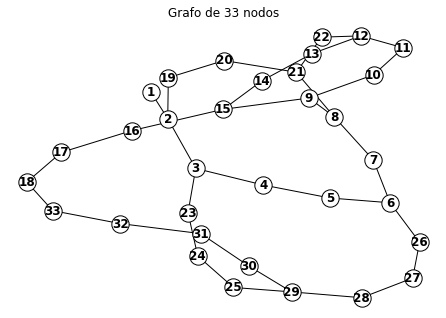

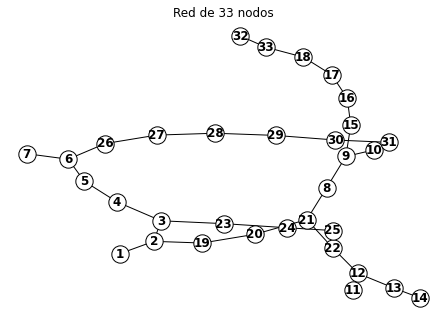

1 - 2, 2 - 3, 3 - 4, 4 - 5, 5 - 6, 6 - 7, 8 - 9, 9 - 10, 12 - 13, 13 - 14, 15 - 16, 16 - 17, 17 - 18, 2 - 19, 19 - 20, 20 - 21, 21 - 22, 3 - 23, 23 - 24, 24 - 25, 6 - 26, 26 - 27, 27 - 28, 28 - 29, 29 - 30, 30 - 31, 9 - 15, 18 - 33, 12 - 11, 33 - 32, 21 - 8, 22 - 12, 


In [7]:

m.optimize() #optimiza modelo
m.write("modelo33.lp")#escribe un archivo con el modelo
m.status #muestra el eestatus del modelo

#Si el modelo es óptimo grafica el grafo y la red
#Si no calcula el IIS
if m.status == GRB.OPTIMAL:
    print('Tiempo Corrida: ', m.RunTime)
    # Visulizar el valor de la función objetivo
    print('Costo:', m.objVal)
    
    red=[]
    grafo=[]
    estilo=[]
    #Hace lista con arcos que pretenecen a la solución.
    for (i, j) in B:
            print(f"y[{i},{j}]: {y[i, j].X}")
            if y[(i,j)].X>=1:
                red.append((i,j))
                estilo.append('solid')
            elif B.index((i,j)) <len(B)/2: 
                estilo.append('dashed')
            if B.index((i,j)) <len(B)/2:    
                grafo.append((i,j))

    G = nx.Graph()
    
    G.add_nodes_from(N)
    
    G.add_edges_from(grafo)
    nx.draw(G, with_labels=True, node_color="white", font_weight='bold', edgecolors='black')
    plt.title("Grafo de 33 nodos")
    plt.show()
    
    G1 = nx.Graph()    
    G1.add_nodes_from(N)
    
    G1.add_edges_from(red)
    nx.draw(G1, with_labels=True, node_color="white", font_weight='bold', edgecolors='black')
    plt.title("Red de 33 nodos")
    plt.show()
    
    p=""
    for i,j in red:
        p+=str(i)+" - "+str(j)+ ", "
    print(p)
else:
    m.computeIIS()
    m.write("modelo5.ilp")

# Tunear

In [8]:
m.tune()
for i in range(m.tuneResultCount):
    m.getTuneResult(i)
m.optimize()
print(m.RunTime)


Solving model using baseline parameter set with TimeLimit=3600s

Testing candidate parameter set 1...

	MIPGap 1e-08
	NonConvex 2

Solving with random seed #1 ...
Optimize a model with 610 rows, 403 columns and 1768 nonzeros
Model fingerprint: 0x9acad92a
Model has 74 quadratic constraints
Variable types: 329 continuous, 74 integer (74 binary)
Coefficient statistics:
  Matrix range     [4e-05, 5e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e-03, 2e+02]
Presolve removed 188 rows and 6 columns
Presolve time: 0.01s
Presolved: 422 rows, 397 columns, 1520 nonzeros
Presolved model has 73 quadratic constraint(s)
Variable types: 325 continuous, 72 integer (72 binary)

Root relaxation: objective 0.000000e+00, 121 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

# Mejoras en el modelo 

1) Se unificaron las variables I y I^2 con lo que se reduce la cantidad de arcos y se logra una mejora en el tiempo computacional 

2) Se elimina la restricción de que los nodos de referencia no generan ya que con el enfoque utilizado no es necesaria. Con el fin de evitar ciclos en la solución final se añade una nueva restricción.

3) Mediante la optimización de parámetros (tuning) en nuestro modelo computacional, hemos alcanzado una notable mejora en el tiempo de ejecución. Pasamos de 0.17 segundos a tan solo 0.049 segundos, marcando una reducción significativa y eficaz en el tiempo computacional. Este logro destaca la eficiencia de ajustar cuidadosamente los parámetros del modelo, permitiéndonos alcanzar resultados óptimos de manera más rápida y efectiva.